In [ ]:
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

In [2]:
from tensorflow import keras
from tensorflow.keras import Model, layers, losses
import tensorflow as tf
Layer=keras.layers.Layer
Conv2D=keras.layers.Conv2D
MaxPool2D=keras.layers.MaxPooling2D
Dense=keras.layers.Dense
Flatten=keras.layers.Flatten
Reshape=keras.layers.Reshape

class Time2Vector(Layer): #Time embedding layer
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

In [3]:
class SingleAttention(Layer): #Attention layer
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out 

In [4]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, h, d_f):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.heads = h
        self.d_f = d_f
        self.attn_layers = []
        
    def build(self, input_shape):
        for head in range(self.heads):
            self.attn_layers.append(SingleAttention(self.d_k, self.d_v))
        self.dense = Dense(self.d_f, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    
    def call(self, input):
        attention = [self.attn_layers[i](input) for i in range(self.heads)]
        conc_attention = tf.concat(attention, axis=1)
        mlp = self.linear(conc_attention)
        return mlp

In [5]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, h, d_f, d_filt):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.heads = h
        self.d_f = d_f
        self.d_filt = d_filt
    def build(self, input_shape):
        self.multi_head = MultiAttention(self.d_k, self.d_v, self.h, self_d_f)
        self.dropout = Dropout(rate=0.2)
        self.norm1 = LayerNormalization(epsilon=0.0001)
        self.conv1 = Conv2D(filters=self.d_f, kernel_size=1, activation='relu')
        self.conv2 = Conv2D(filters=self.d_filt, kernel_size=1)
        self.norm2 = LayerNormalization(epsilon=0.0001)
        
    
    def call(self, input):
        res = input[0]
        
        #Attention
        x = self.multi_head(input)
        x = self.dropout(x)
        x = self.norm1(x + res)
        
        #Feed-forward
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm2(x + res)
        
        return x

## Data processing

In [6]:
from tqdm import trange
def retrieve_data(data_size):
    frames = []

    for d in trange(data_size):
        video = dataset.update().resolve()
        for frame in video:
            frames.append(frame)

    return tf.stack(frames)

data_size = 1000

# Save the data
data = retrieve_data(data_size)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:04<00:00,  1.18it/s]


In [7]:
np.save('video_data.npy', data)

In [6]:
# Load if data is already generated
data = np.load('video_data.npy')

#### Split into training and validation data

In [53]:
num_frames = len(data)
train_size = int(num_frames * 0.8)
val_size = num_frames - train_size

train_data = data[:train_size]
val_data = data[train_size:]

max_val = tf.reduce_max(tf.concat([train_data, val_data], axis=0))
train_data /= max_val
val_data /= max_val

print("Training data size:", train_data.shape)
print("Validation data size:", val_data.shape)

Training data size: (8000, 64, 64, 1)
Validation data size: (2000, 64, 64, 1)


## Task 1
The first step is to pretrain the convolution encoder and decoder as an autoencoder. In other words, during this step of the training, frames are passed through
the convolutional encoder individually, and the output from the encoder is passed
directly to the decoder. The job of the decoder is to reconstruct the original video
frame from the downsampled representation provided by the convolutional encoder.
How does the performance of the autoencoder depend on the number of features
extracted at the bottleneck? 

#### Convolutional Autoencoder

In [49]:
Conv2D=keras.layers.Conv2D
MaxPool2D=keras.layers.MaxPooling2D
Dense=keras.layers.Dense
Flatten=keras.layers.Flatten
Reshape=keras.layers.Reshape
Input = keras.layers.Input
Sequential = keras.Sequential
Conv2DTranspose = keras.layers.Conv2DTranspose

k_size = 4
n_filters = 16
bottleneck_size = k_size**2*n_filters
print(bottleneck_size)
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
            Conv2D(64, (4, 4), activation='relu', padding='same', strides=4),
            Conv2D(n_filters, (k_size, k_size), activation='relu', padding='same', strides=4),
            Flatten()
            ])
        
        bottleneck_size = k_size**2*n_filters
        self.decoder = Sequential([
            Input(shape=(bottleneck_size,)),
            Reshape(target_shape=(4, 4, n_filters)),
            Conv2DTranspose(n_filters, (4, 4), strides=(4, 4), activation='relu', padding='same'),
            Conv2DTranspose(64, (8, 8), strides=(4, 4), activation='relu', padding='same'),
            Conv2D(1, (1, 1), activation='linear', padding='same')
            ])
    def call(self, input):
        x = self.encoder(input)
        x = self.decoder(x)
        return x



autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.encoder.build(input_shape=(None, 64, 64, 1))
autoencoder.encoder.summary()

autoencoder.decoder.build(input_shape=(None, bottleneck_size))
autoencoder.decoder.summary()

1600
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        1088      
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 100)         102500    
                                                                 
 flatten_6 (Flatten)         (None, 1600)              0         
                                                                 
Total params: 103,588
Trainable params: 103,588
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_1

In [ ]:
# Implement early stopping to stop the algorithm when validation loss stagnates
# Start tracking from epoch 5, stop after 5 epochs of no improvement, store the best weights found, monitor over val_loss.
# If improvement isnt larger then 1e-4 it is counted towards patience


callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.0001, monitor='val_loss', patience=5, verbose=1, start_from_epoch=5,
                                            restore_best_weights=True)

autoencoder.fit(train_data, train_data,
                epochs=40,
                shuffle=True,
                validation_data=(val_data, val_data),
                callbacks=[callback])

autoencoder.save('autoencoder_bottleneck_size='+str(bottleneck_size))

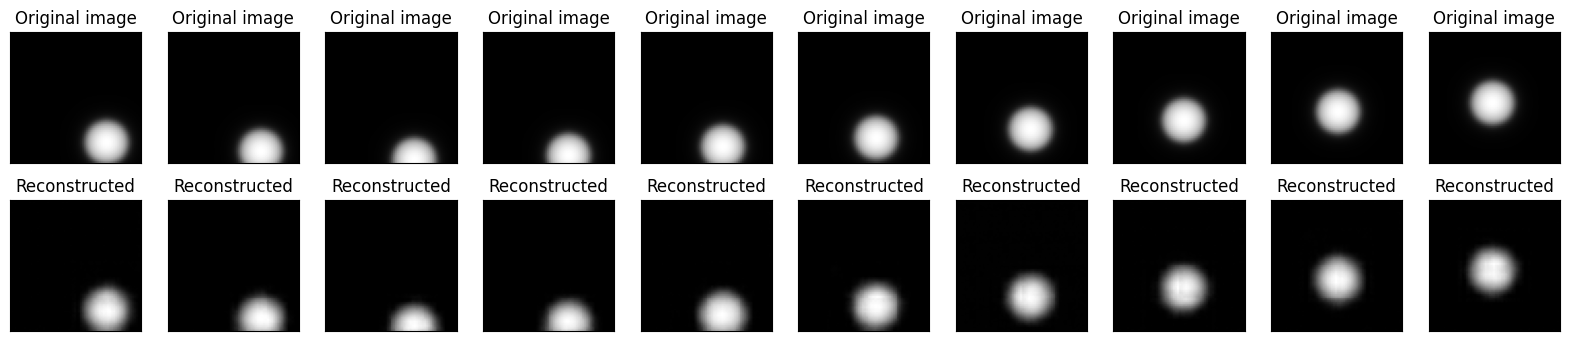

In [56]:
# Saved autoencoders with different bottleneck sizes

#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=1600')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=256')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=128')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=64')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=16')

import matplotlib.pyplot as plt

n = sequence_length

original_frames = val_data[0:sequence_length]
encoded_frames = autoencoder.encoder(original_frames).numpy()
decoded_frames = autoencoder.decoder(encoded_frames).numpy()

plt.figure(figsize=(20, 4))

for i in range(sequence_length):
    # Display original frames
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(original_frames[i]))
    plt.title("Original image")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed frames
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(decoded_frames[i]))
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [57]:
# Define the list of autoencoder models to evaluate
autoencoder_models = {
    'autoencoder_256': tf.keras.models.load_model('autoencoder_bottleneck_size=256'),
    'autoencoder_128': tf.keras.models.load_model('autoencoder_bottleneck_size=128'),
    'autoencoder_64': tf.keras.models.load_model('autoencoder_bottleneck_size=64'),
    'autoencoder_16': tf.keras.models.load_model('autoencoder_bottleneck_size=16')
}

# Loop over the autoencoder models and evaluate the reconstruction loss
for model_name, model in autoencoder_models.items():
    test_loss = model.evaluate(val_data, val_data)
    print(f'{model_name}: Reconstruction loss = {test_loss:.4e}')

63/63 [==============================] - 4s 58ms/step - loss: 3.3310e-06
autoencoder_256: Reconstruction loss = 3.3310e-06
63/63 [==============================] - 4s 61ms/step - loss: 1.2435e-05
autoencoder_128: Reconstruction loss = 1.2435e-05
63/63 [==============================] - 4s 60ms/step - loss: 6.5160e-05
autoencoder_64: Reconstruction loss = 6.5160e-05
63/63 [==============================] - 4s 61ms/step - loss: 0.0126
autoencoder_16: Reconstruction loss = 1.2620e-02


### Discussion about autoencoder bottleneck size
The performance of an autoencoder typically depends on various factors, including the architecture of the network, the size of the training dataset, and the complexity of the input data. However, in general, the number of features extracted at the bottleneck can have a significant impact on the performance of the autoencoder.

If the number of features extracted at the bottleneck is too small, the autoencoder may not be able to capture all of the important information in the input data. This can lead to poor reconstruction performance and loss of important details in the output.

On the other hand, if the number of features extracted at the bottleneck is too large, the autoencoder may overfit to the training data and fail to generalize well to new, unseen data. Additionally, a larger bottleneck can increase the computational complexity of the model, making it more difficult and expensive to train.

Therefore, finding the optimal number of features to extract at the bottleneck requires balancing the need for a compact representation of the input data with the requirement for accurate reconstruction and good generalization performance. This is often achieved through experimentation and fine-tuning of the autoencoder architecture and hyperparameters.

## Task 2
After pretraining decoder/encoder pair, train the transformer encoder to predict
the downsampled representation of the next video frame. Remember to keep the
pretrained weights of the convolutional encoder/decoder fixed at this stage! Experiment with different number of transformer layers of different sizes. Do these
parameters influence the performance of the network? How far ahead can the transformer predict the sequence of frames? 

In [ ]:
Conv2D=keras.layers.Conv2D
MaxPool2D=keras.layers.MaxPooling2D
Dense=keras.layers.Dense
Flatten=keras.layers.Flatten
Reshape=keras.layers.Reshape
Input = keras.layers.Input
Sequential = keras.Sequential
Conv2DTranspose = keras.layers.Conv2DTranspose
Model = tf.keras.Model

# Load the autoencoder you want
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=1600')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=256')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=128')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=64')
#autoencoder = tf.keras.models.load_model('autoencoder_bottleneck_size=16')

#Keep weights the same
autoencoder.trainable = False
autoencoder.encoder.trainable = False
autoencoder.decoder.trainable = False


# Parameters
bottleneck_size = ...
latent_dim = ...
d_k = ...
d_v = ...
n_heads = ...
d_f = ...
d_filt = ...
seq_len = 10


def transformer_model()
    time_embd = Time2Vector(seq_len)
    attentionL1 = TransformerEncoder(d_k, d_v, h, d_f, d_filt)
    attentionL2 = TransformerEncoder(d_k, d_v, h, d_f, d_filt)
    
    input_sequence = Input(shape=(seq_len, bottleneck_size))
    x = time_embd(input_sequence)
    x = attentionL1(x)
    x = attentionL2(x)
    out = autoencoder.decoder(x)
    
    model = Model(inputs=in_seq, outputs=out)
    model.compile(optimizer='adam', loss=losses.MeanSquaredError())
    return model